# Analysing a single NuSTAR observation

## Learning Goals

By the end of this tutorial, you will:

- Understand how to search for and download observational data for NuSTAR and other missions.
- Re-run the data reduction pipeline to produce clean event files.
- Use heasoftpy to extract data products and start the analysis.


## Introduction
In this tutorial, we will go through the steps of analyzing a NuSTAR observation of the active galactic nuclei (AGN) in the center of `SWIFT J2127.4+5654` using `heasoftpy`.

Most of the X-ray mission data hosted at the HEASARC is analyzed using the legacy [HEASoft](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/) package. In this tutorial, we walk through the steps needed to extract the spectral and timing products of AGN using NuSTAR data.

We will specifically focus on analyzing one observation (`60001110002`) of the Narrow Line Seyfert 1 galaxy `SWIFT J2127.4+5654`.

### Inputs

- The name of the source of interest.
- The ObsID of the single observation we wish to use.

### Outputs

- Light curves for the source and background.
- Spectra for the source and background.
- Visualizations of the light curve and spectra.
- Fitted spectral model parameters.

### Runtime

As of 7th October 2025, this notebook takes ~25m to run to completion on Fornax using the 'High-Energy Astrophysics' image and the 'small’ server with 8GB RAM/ 2 cores.


## Imports

We assume `heasoftpy` and HEASoft are present on your system; installing the [heasoft conda package](https://heasarc.gsfc.nasa.gov/docs/software/conda.html) may be the easiest option.
The following command will set up a new Conda environment with the latest version of HEASoft installed (you may substitute 'conda' with 'mamba', or whichever skew of Conda you use):

```
conda create -n hea_env heasoft -c https://heasarc.gsfc.nasa.gov/FTP/software/conda
```

You may also install HEASoft from source following the [standard installation instructions](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/#install).

As this guide uses `heasoftpy`, be sure to set the 'PYTHON' environment variable before building HEASoft from source; otherwise heasoftpy may not function correctly.
We note that the analyses performed in this notebook can also be run using the equivalent 'traditional' HEASoft commands in the command line.

We also use `xspec` to load the spectra data products.

Finding and downloading data is down using the [heasarc](https://astroquery.readthedocs.io/en/latest/heasarc/heasarc.html) module in `astroquery`. Also, if downloading data from Amazon Web Services, install `boto3` too.

We also use `astropy` to handle coordinates, units, and the reading of FITS files, and `matplotlib` for plotting.

**Fornax & SciServer**: When running this on [Fornax](https://docs.fornax.sciencecloud.nasa.gov/) or [SciServer](https://heasarc.gsfc.nasa.gov/docs/sciserver/), make sure to select the heasoft kernel from the drop-down list in in the top-right of this notebooks.

In [1]:
import os

import heasoftpy as hsp
import matplotlib.pyplot as plt
import xspec as xs
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.heasarc import Heasarc
from matplotlib.ticker import FuncFormatter

# supress the deprecation warning
hsp.Config.allow_failure = True

%matplotlib inline

## Global Setup

### Functions

In [2]:
# This cell will be automatically collapsed when the notebook is rendered, which helps
#  to hide large and distracting functions while keeping the notebook self-contained
#  and leaving them easily accessible to the user

### Constants

In [3]:
# Global input variables
SOURCE = "SWIFT J2127.4+5654"
OBS_ID = "60001110002"
WORK_DIR = os.getcwd()

### Configuration

In [4]:
# Modifiy the style of all plots produced in this notebook
plt.rcParams.update(
    {
        "font.size": 14,
        "lines.markersize": 5.0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.major.size": 9.0,
        "ytick.major.size": 9.0,
    }
)

***


## 1. Considering the steps needed to extract the data products

The steps we will follow are:
- Find and download the data.
- Re-run the NuSTAR pipeline to produce clean events files using `nupipeline`.
- Extract the data products using `nuproducts`.

## 2. Find and Download Data

HEASARC data holdings can be accessed in many different ways. The `astroquery` and `pyvo` modules provide a variety of ways to access our data when using Python.

- `astroquery` - provides high-level access with convenience functions for general usage.
- `pyvo` - uses Virtual Observatory protocols to offer more powerful low-level access that supports [complex queries](https://nasa-navo.github.io/navo-workshop/content/reference_notebooks/catalog_queries.html).

***

In our case, we are looking for data for a specific object in the sky. The steps are:
1. Find the name of the NuSTAR master catalog (if not already known).
2. Query the catalog for observations of the source of interest.
3. Locate the corresponding data.
4. Download the data of interest.

### Searching for the NuSTAR master catalog of observations

In [5]:
# Find the name of the NuSTAR master catalog
catalog_name = Heasarc.list_catalogs(master=True, keywords="nustar")[0]["name"]

print(f"NuSTAR master catalog: {catalog_name}")

NuSTAR master catalog: numaster


### Querying the NuSTAR master catalog for observations of our source

In [6]:
# Find the coordinates of the source
position = SkyCoord.from_name(SOURCE)

# Query the archive for a list of observations
observations = Heasarc.query_region(position, catalog=catalog_name)
observations

name,ra,dec,time,obsid,status,exposure_a,observation_mode,obs_type,processing_date,public_date,issue_flag,__row
,deg,deg,d,,,s,,,d,d,,
object,float64,float64,float64,object,object,float64,object,object,float64,int32,int16,object
SwiftJ2127d4p5654,321.8865,56.8893,56235.7230,60001110002,archived,49200,SCIENCE,AGN,59170.4000,56694,0,5735
SWIFT_J2127d4p5654,321.9575,56.9122,58482.3272,60402008010,archived,74246,SCIENCE,N04,59061.8000,58859,0,5740
SwiftJ2127d4p5654,321.9125,56.9214,56236.7542,60001110003,archived,28764,SCIENCE,AGN,59170.4000,56694,0,5741
SwiftJ2127d4p5654,321.9235,56.9256,56237.7473,60001110005,archived,74578,SCIENCE,AGN,59170.4000,56694,1,5742
SwiftJ2127d4p5654,321.9412,56.9294,56239.7022,60001110007,archived,42106,SCIENCE,AGN,59170.3000,56694,0,5743
SWIFT_J2127d4p5654,321.8852,56.9316,58375.6952,60402008008,archived,72875,SCIENCE,N04,59065.6000,58859,0,5744
SWIFT_J2127d4p5654,321.9207,56.9606,58304.6848,60402008002,archived,71255,SCIENCE,N04,59073.1000,58859,1,5745
SWIFT_J2127d4p5654,321.8877,56.9639,58329.8550,60402008006,archived,72130,SCIENCE,N04,59072.5000,58859,0,5746


### Selecting our one observation

In [7]:
# Filter the observations table to the one ObsID we will use
selected_obs = observations[observations["obsid"] == OBS_ID]
selected_obs

name,ra,dec,time,obsid,status,exposure_a,observation_mode,obs_type,processing_date,public_date,issue_flag,__row
,deg,deg,d,,,s,,,d,d,,
object,float64,float64,float64,object,object,float64,object,object,float64,int32,int16,object
SwiftJ2127d4p5654,321.8865,56.8893,56235.7230,60001110002,archived,49200,SCIENCE,AGN,59170.4000,56694,0,5735


### Locating and downloading the data

In [8]:
# Find where the data is stored
links = Heasarc.locate_data(selected_obs)

# Download the data, selecting the correct value of the argument based on where
#  you are running the notebook
os.chdir(WORK_DIR)

#
if os.path.exists("../../../_data"):
    data_dir = "../../../_data/NuSTAR/"
else:
    data_dir = ""

if not os.path.exists(data_dir):
    # Heasarc.download_data(links, location=data_dir)
    Heasarc.download_data(links, host="aws", location=data_dir)
    # Heasarc.download_data(links, host='sciserver', location=data_dir)

## 3. Data Reduction

Next, we use `nupipeline` ([see the pipeline description here](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nupipeline.html)) to process the raw observation into a set of science-ready data products.

As we show in the HEASoftPy Getting Started tutorial, we can either call `hsp.nupipeline` or create an instance of `hsp.HSPTask`. Here, we use the former

Note that to run `nupipeline`, only three parameters are needed: `indir`, `outdir` and `steminput`. By default, calling the task will also query for other parameters. We can instruct the task to use default values by setting `noprompt=True`.

Also, because `nupipeline` takes some time to run (up to tens of minutes), and we wish to track its progress, we make sure the task output prints to screen by setting `verbose=True`.

```{admonition} caution
If, in your version of this notebook, you are processing _many_ NuSTAR observations, be aware that printing the output may result in some amount of slowdown.
```

For the purposes of this tutorial, we will focus only on the `FMPA` instrument (NuSTAR has two nominally identical telescopes and instruments: `FPMA` and `FPMB`).

If we want to store the processed, science-ready, NuSTAR data in the `60001110002_p/event_cl` directory, the call may look something like:

In [9]:
# call the pipeline tasks
os.chdir(WORK_DIR)
out = hsp.nupipeline(
    indir=data_dir + f"{OBS_ID}",
    outdir=f"{OBS_ID}_p/event_cl",
    steminputs=f"nu{OBS_ID}",
    instrument="FPMA",
    clobber="yes",
    noprompt=True,
    verbose=True,
)


                 Running NuSTAR pipeline
 Task: nupipeline Version: 0.4.12 Release Date: 2023-11-16
nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - TELDEF 2012-11-04 17:21:07 "-" retrieve+ clobber=yes
CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuA20100101v002.teldef 0
nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPM - - ALIGNMENT 2012-11-04 17:21:07 "type.eq.systems" retrieve+ clobber=yes
CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuCalign20120101v001.fits 1
------------------------------------------------------------
               Setting Optical Axis Direction
------------------------------------------------------------
nupipeline_0.4.12: Info: 'pntra' and/or 'pntdec' input parameter set to POINT
nupipeline_0.4.12: Info: getting default S/C direction
nupipeline_0.4.12: Info: Optical Axis   RA : 3.2188650000000E+02(deg)
nupipeline_0.4.12: Info: Optical Axis  DEC : 5.6889300000000E+01(deg)
nupipeline_0.4.12: Info: 

In [10]:
# A return code of `0`, indicates that the task ran successfully!
assert out.returncode == 0

The most important outputs are the cleaned event files:
- `nu60001110002A01_cl.evt` -  for NuSTAR module 'A' (FPMA)
- `nu60001110002B01_cl.evt` - for NuSTAR module 'B' (FPMA)


## 4. Extracting a light curve
Now that we have data processed, we can proceed and extract a light curve for the source. For this, we use `nuproducts` (see [nuproducts](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nuproducts.html) for details)

First, we need to create source and background region files.

The source region is a circle centered on our target's coordinates with a radius of 150 arcseconds, while the background region is an annulus with inner and outer radii of 180 and 300 arcseconds respectively.

In [11]:
# write region files
src_pos = position.to_string("hmsdms", sep=":").replace(" ", ", ")
src_region = f'circle({src_pos}, 150")'
with open("src.reg", "w") as fp:
    fp.write(src_region)

bgd_region = f'annulus({src_pos}, 180", 300")'
with open("bgd.reg", "w") as fp:
    fp.write(bgd_region)

params = {
    "indir": f"{OBS_ID}_p/event_cl",
    "outdir": f"{OBS_ID}_p/lc",
    "instrument": "FPMA",
    "steminputs": f"nu{OBS_ID}",
    "binsize": 256,
    "bkgextract": "yes",
    "srcregionfile": "src.reg",
    "bkgregionfile": "bgd.reg",
    "imagefile": "none",
    "phafile": "DEFAULT",
    "bkgphafile": "DEFAULT",
    "runbackscale": "yes",
    "correctlc": "yes",
    "runmkarf": "no",
    "runmkrmf": "no",
}

# verbose=20 so the output is logged to a file
os.chdir(WORK_DIR)
out = hsp.nuproducts(params, noprompt=True, verbose=20, logfile="nuproducts_lc.log")

In [12]:
# A return code of `0`, indicates that the task ran successfully!
assert out.returncode == 0

If we look at the entire contents of the output directory `60001110002_p/lc`, we see that running this task has created both source and background light curves (`nu60001110002A01_sr.lc` and `nu60001110002A01_bk.lc`), along with corresponding spectra.

The task also generates `.flc` file, which contains the background-subtracted light curves.

We can then proceed in different ways; for example, we may use the `astropy.io.fits` package in to read these FITS-formatted light curve file directly, or we could use `ftlist` to dump the content of that file to an ascii file before reading it (we use `option=T` to list the table content).

For this example we're going to go with the first option, and use `astropy` to read the light curve, then use matplotlib to plot all data points with a fractional exposure higher than 0.5:

In [13]:
os.chdir(WORK_DIR)
with fits.open(f"{OBS_ID}_p/lc/nu{OBS_ID}A01.flc") as fp:
    frac_exposure = fp["rate"].data.field("FRACEXP")
    igood = frac_exposure > 0.5
    time = fp["rate"].data.field("time")[igood]
    rate = fp["rate"].data.field("rate1")[igood]
    rerr = fp["rate"].data.field("error1")[igood]

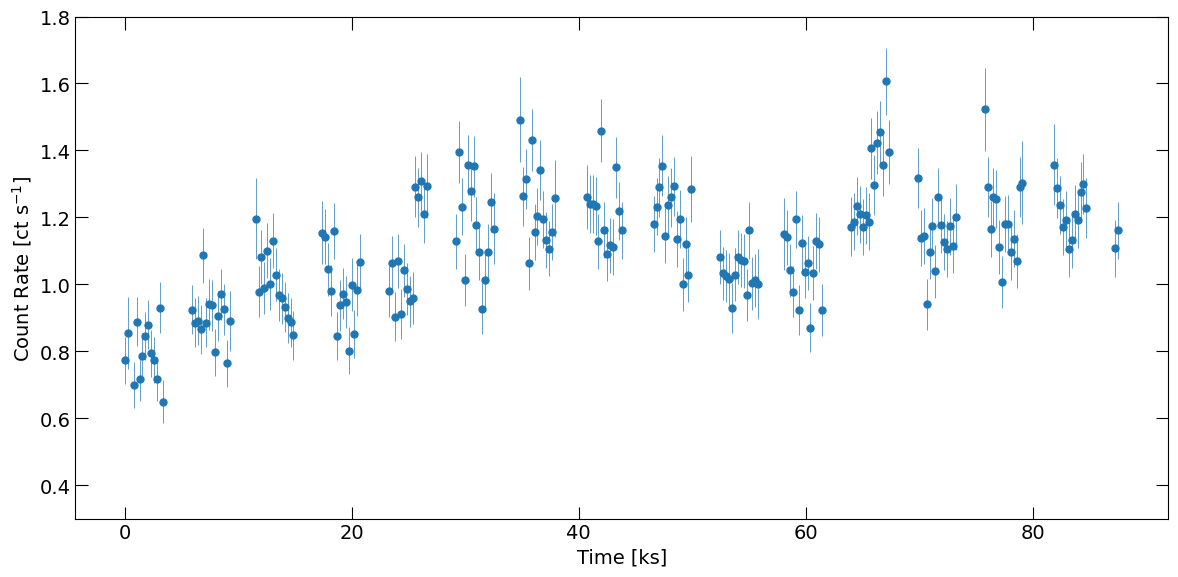

In [14]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(time / 1e3, rate, rerr, fmt="o", lw=0.5)
plt.xlabel("Time [ks]", fontsize=14)
plt.ylabel(r"Count Rate [ct s$^{-1}$]", fontsize=14)
plt.ylim([0.3, 1.8])

plt.tight_layout()
plt.show()

## 5. Extracting the spectrum
In a similar way, we use `nuproducts` (see [nuproducts](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nuproducts.html) for details) to extract the source spectrum.

In [15]:
params = {
    "indir": f"{OBS_ID}_p/event_cl",
    "instrument": "FPMA",
    "steminputs": f"nu{OBS_ID}",
    "outdir": f"{OBS_ID}_p/spec",
    "bkgextract": "yes",
    "srcregionfile": "src.reg",
    "bkgregionfile": "bgd.reg",
    "phafile": "DEFAULT",
    "bkgphafile": "DEFAULT",
    "runbackscale": "yes",
    "runmkarf": "yes",
    "runmkrmf": "yes",
}
os.chdir(WORK_DIR)
out = hsp.nuproducts(params, noprompt=True, verbose=20, logfile="nuproducts_spec.log")

In [16]:
# A return code of `0`, indicates that the task ran successfully!
assert out.returncode == 0

Next, we want to group the spectrum so we can model it in XSPEC using $\chi^2$ minimization.

For that, we use `ftgrouppha` (see the [detailed documentation](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/ftgrouppha.html)) to bin the spectrum using the optimal binning with a minimum signal to noise ratio of 6.

In [17]:
os.chdir(f"{WORK_DIR}/{OBS_ID}_p/spec")
out = hsp.ftgrouppha(
    infile=f"nu{OBS_ID}A01_sr.pha",
    outfile=f"nu{OBS_ID}A01_sr.grp",
    grouptype="optsnmin",
    groupscale=6,
    respfile=f"nu{OBS_ID}A01_sr.rmf",
    clobber=True,
)
assert out.returncode == 0

## 6. Using pyXspec to load, fit, and plot a spectrum
Our next step is to load the spectrum into `pyXspec` (a Python-based interface to the ubiquitous X-ray spectral fitting tool, XSPEC). Alternatively, you could switch to your terminal and use `xspec` in the command line.

This is going to let us fit a model to the spectrum we've created for our AGN, which will allow us to parameterize how the emission changes across NuSTAR's considerable energy range.

### Loading the spectrum

We'll start by navigating to the directory where we generate the spectrum product, just to make the path we supply to pyXspec a little nicer to look at.

When it comes to using pyXspec to load the spectrum, we first run the `AllData.clear()` method - this will ensure that any existing loaded data are removed. We _know_ there are no existing data loaded in this tutorial, but it is still good practice (particularly in notebook environments where variables persist across cells).

Also note that we 'ignore' any spectral data points below 3 keV and above 79 keV - this represents NuSTAR's effective energy range, and any data points outside are likely to be dubious.

In [18]:
os.chdir(f"{WORK_DIR}/{OBS_ID}_p/spec")
xs.AllData.clear()
spec = xs.Spectrum(f"nu{OBS_ID}A01_sr.grp")
spec.ignore("0.0-3.0, 79.-**")


1 spectrum  in use
 
Spectral Data File: nu60001110002A01_sr.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.233e-01 +/- 4.268e-03 (86.7 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-202
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 4.92e+04 sec
 Using fit statistic: chi
 Using Background File                nu60001110002A01_bk.pha
  Background Exposure Time: 4.92e+04 sec
 Using Response (RMF) File            nu60001110002A01_sr.rmf for Source 1
 Using Auxiliary Response (ARF) File  nu60001110002A01_sr.arf

     8 channels (1-8) ignored in spectrum #     1
    48 channels (155-202) ignored in spectrum #     1



### Fitting a spectral model

To demonstrate how to fit a spectral model, we perform an extremely simple fit to a powerlaw.

In many situations you may want to set start values for the parameters of the model, and you should visit the [pyXspec documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html) for more information.

```{admonition} seealso
A full list of XSPEC models can be [found here](https://heasarc.gsfc.nasa.gov/docs/software/xspec/manual/node128.html)
```

In [19]:
model = xs.Model("powerlaw")
xs.Fit.perform()


Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.752453e+10     using 146 bins.

Test statistic : Chi-Squared              1.752453e+10     using 146 bins.
 Null hypothesis probability of 0.000000e+00 with 144 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl    1:PhoIndex        2:norm
5474.57      3377.32      -2       1.56029    0.00280893
3371.45      1.25606e+06  -3       1.94147    0.00695747
552.776      461968       -4       1.73916    0.00747390
267.194      200426       -5       1.79994    0.00776213
266.56       6700.42      -6       1.80600    0.00782891
266.56       43.7918 

### Plotting the fitted spectrum

The pyXspec module provides a 'Plot' object, from which we can extract all the information required to plot the spectrum.

We could generate visualization of the spectrum using just that 'Plot' object, but instead we demonstrate how to plot the spectrum using the matplotlib module.

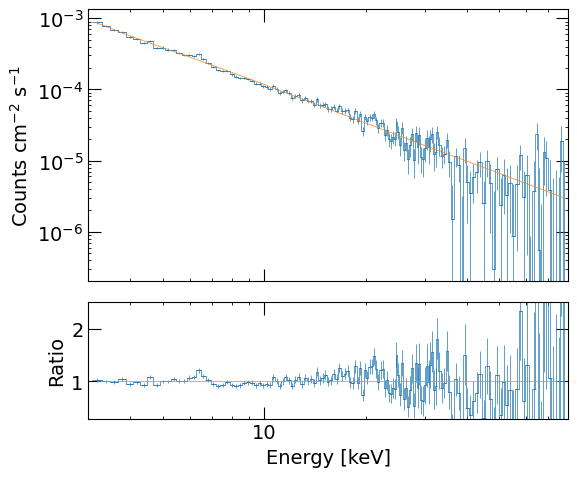

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True, height_ratios=(0.7, 0.3))
fig.subplots_adjust(hspace=0)

# Plot the spectral data
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot("data")
xval, xerr, yval, yerr = xs.Plot.x(), xs.Plot.xErr(), xs.Plot.y(), xs.Plot.yErr()
axs[0].step(xval, yval, color="C0", where="mid", lw=0.5)
axs[0].errorbar(xval, yval, yerr, fmt=".", ms=0, xerr=xerr, lw=0.5)

# Plot the fitted model as well
axs[0].loglog(xval, xs.Plot.model(), lw=0.5)

# Set up axis limits and labels
axs[0].set_xlim(3, 80)
axs[0].set_ylabel("Counts cm$^{-2}$ s$^{-1}$")

# plot the ratio
xs.Plot("ratio")
xval, xerr, yval, yerr = xs.Plot.x(), xs.Plot.xErr(), xs.Plot.y(), xs.Plot.yErr()
axs[1].step(xval, yval, color="C0", where="mid", lw=0.5)
axs[1].errorbar(xval, yval, yerr, fmt=".", ms=0, xerr=xerr, lw=0.5)
axs[1].plot([xval[0], xval[-1]], [1, 1], "-", lw=0.5)
axs[1].set_ylim(0.3, 2.5)

# Set up axis limits and labels
axs[1].set_xlabel("Energy [keV]")
axs[1].set_ylabel("Ratio")
# Also, format the x-axis tick labels to be shown as integers rather than powers
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

In [21]:
# do some cleanup
os.chdir(WORK_DIR)
ret_code = os.system(
    "rm -f nuAhkrange* nuA*teldef nuAcutevt* nuCal*fits nuCmk*fits nuCpre*fits *.reg"
)

## About this Notebook
**Author:** Abdu Zoghbi, HEASARC Staff Scientist.\
**Updated On:** 2025-10-03

### Additional Resources

For other examples of finding and analyzing data, take a look at these tutorials:

### Acknowledgements

### References